In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [2]:
img_l = np.asanyarray(Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)

## Params definition

In [3]:
kg_max=45
kv_max=14
kv_half = kv_max//2
height = img_r.shape[0]
length = img_r.shape[1]

In [4]:
#import shelve

In [5]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [6]:
#np.save("img_shift.npy", img_shift2)

In [7]:
img_shift2 = np.load("img_shift.npy")

In [8]:
from scipy import ndimage

In [9]:
#k = np.ones((3,3))/9
#img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
#img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
#Image.fromarray((255.9*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [10]:
from random import choices
from scipy.linalg import null_space

In [11]:
def is_smooth(img_shift, x, y, radius=1):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True


map2draw = np.zeros((img_r.shape), dtype=np.uint8)

pairs = []
rejected_pairs = []
# (X, X')
for y_r in range(30, img_r.shape[0] - 30):
    for x_r in range(30, img_r.shape[1] - 30):
        x_r3d = [x_r, y_r, 1]
        
        dot_shift = img_shift2[y_r, x_r]
        
        x_l = int(x_r - dot_shift[0])
        y_l = int(y_r - (dot_shift[1] - kv_half))
        x_l3d = [x_l, y_l, 1]
        
        if is_smooth(img_shift2, x_r, y_r):
            pairs.append([x_l3d, x_r3d])
            map2draw[y_r, x_r] = 255
        else:
            rejected_pairs.append([x_l3d, x_r3d])

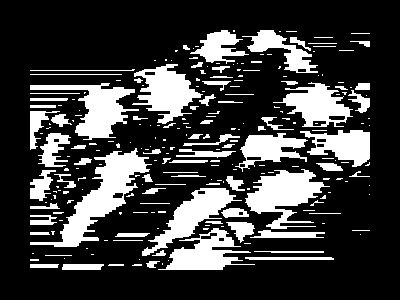

In [12]:
Image.fromarray(map2draw)

In [13]:
len(pairs)

28908

In [14]:
len(rejected_pairs)

52692

In [15]:
Boundary = 1e-4
bestF = None
bestScore = 0

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

for iteration in range(20000):
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for left, right in seven_pairs:
        x_l, y_l, z_l = left
        x_r, y_r, z_r = right
        X_big.append([x_r*x_l, x_r*y_l, x_r*z_l,
                      y_r*x_l, y_r*y_l, y_r*z_l,
                      z_r*x_l, z_r*y_l, z_r*z_l])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([
     np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f1),
    # на попередній лінії була помилка,
    # через яку я декілька місяців не міг зрозуміти чого не працює.
    # вічна пам'ять моїм загиблим нервовим клітинам.
    # F
    ])
    coefs = np.roots(p)
    for i in coefs:
        if np.iscomplex(i):
            continue
        F = f1+float(i)*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', all_right, F, all_left)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            print(epipole)
            epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

hit 0.0006572575065725751
[[0.99494931]
 [0.10037317]
 [0.0010508 ]]
X: 946.8528327709214
Y: 95.52107052667459
hit 0.0010031825100318252
[[-0.99198847]
 [-0.12628118]
 [-0.00345431]]
X: 287.1742623018598
Y: 36.55758595239224
hit 0.001971772519717725
[[-0.91925073]
 [-0.39365936]
 [-0.00322519]]
X: 285.02181437243354
Y: 122.05756272572891


/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


hit 0.002040957520409575
[[-0.80260105]
 [-0.59650765]
 [-0.00318881]]
X: 251.6932953274612
Y: 187.0630192205333
hit 0.002594437525944375
[[0.84310016]
 [0.53774855]
 [0.00293747]]
X: 287.01623158816017
Y: 183.06551117409236
hit 0.004531617545316176
[[-0.73771178]
 [-0.67510654]
 [-0.003534  ]]
X: 208.74674004826207
Y: 191.03163570113165
hit 0.058046215580462156
[[-0.37880599]
 [-0.92546966]
 [-0.00345396]]
X: 109.67298936130972
Y: 267.944608716166
hit 0.2422512799225128
[[-4.47213595e-01]
 [-8.94427191e-01]
 [ 2.66453526e-13]]
X: -1678392485012.5576
Y: -3356784970095.035
hit 0.30693925556939256
[[1.30196129e-11]
 [1.00000000e+00]
 [5.91748872e-14]]
X: 220.01922629774276
Y: 16899060515461.521


## Фундаментальна матриця

In [16]:
np.round(bestF, 2)

array([[  0.  ,   0.  , -19.5 ],
       [ -0.  ,  -0.  ,   0.  ],
       [ 19.5 ,  -0.  , 156.02]])

In [17]:
bestF

array([[ 7.65911924e-15,  1.15504698e-12, -1.95028496e+01],
       [-1.15146391e-12, -5.42101086e-20,  2.57018962e-10],
       [ 1.95028496e+01, -2.63134181e-10,  1.56022797e+02]])

In [18]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [19]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [20]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [21]:
print(round(100*bestScore/len(pairs), 2),"%")

30.69 %


## Епіполярна точка у 3-х координатах

In [22]:
epipole = null_space(bestF, 1e-3)
epipole

array([[1.30196129e-11],
       [1.00000000e+00],
       [5.91748872e-14]])

In [23]:
epipole.reshape(3)

array([1.30196129e-11, 1.00000000e+00, 5.91748872e-14])

In [24]:
np.linalg.det(bestF)

-2.0619330677978086e-17

## Ліве зображення

In [25]:
from PIL import ImageDraw

In [26]:
image2show = Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")
draw = ImageDraw.Draw(image2show)

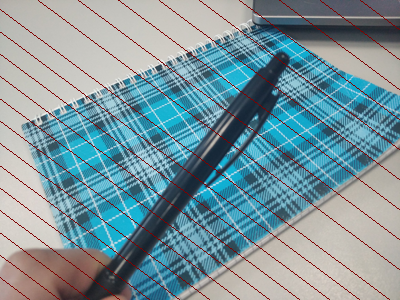

In [27]:
focus_x, focus_y = 200, 150

x_img = 400
for y_img in range(0, 300, 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole.reshape(3)
    x_line1, y_line1, z_line1 = epipole.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole.reshape(3) + (2/3)*diff_vector

    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 10*projected_diff
    projected_p2 = projected_p2 + 10*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)

y_img = 300
for x_img in range(0, 400, 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole.reshape(3)
    x_line1, y_line1, z_line1 = epipole.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole.reshape(3) + (2/3)*diff_vector

    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 10*projected_diff
    projected_p2 = projected_p2 + 10*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)
    
image2show

## Праве зображення

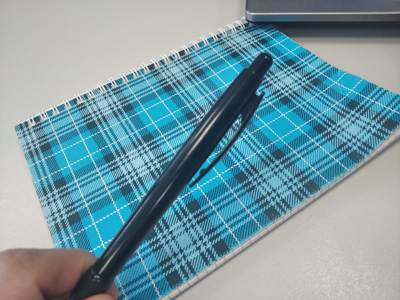

In [28]:
Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")